[View in Colaboratory](https://colab.research.google.com/github/LjBLincoln/Machine_Learning/blob/master/wxplusb.ipynb)

# Demo (y = wx+b)

After 0 training step(s), loss on training batch is 0.128502.
After 50 training step(s), loss on training batch is 0.00363401.
After 100 training step(s), loss on training batch is 0.000753629.
After 150 training step(s), loss on training batch is 0.00015629.
After 200 training step(s), loss on training batch is 3.2412e-05.
After 250 training step(s), loss on training batch is 6.72161e-06.
After 300 training step(s), loss on training batch is 1.39394e-06.
After 350 training step(s), loss on training batch is 2.89104e-07.
After 400 training step(s), loss on training batch is 5.99569e-08.
After 450 training step(s), loss on training batch is 1.24354e-08.


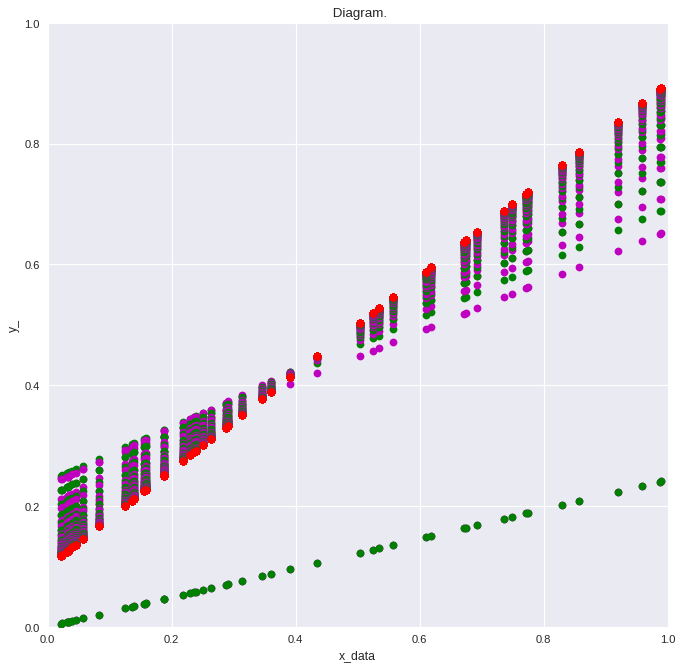

Done !!!
--2018-10-19 09:32:01--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 52.0.94.50, 52.3.53.115, 52.3.63.2, ...
Connecting to bin.equinox.io (bin.equinox.io)|52.0.94.50|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5363700 (5.1M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]   5.11M  32.1MB/s    in 0.2s    

2018-10-19 09:32:01 (32.1 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [5363700/5363700]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   
https://aa3f94d5.ngrok.io


In [1]:
# _*_ coding: utf-8 _*_

import matplotlib.pyplot as plt

import tensorflow as tf

import numpy as np

MAX_STEPS = 500

# create data 生成100个0-1之间的随机数   np.random.rand(100) 1*100的矩阵
#np.random.rand(3,3) 3*3的矩阵，其每个元素为0-1的随机数
x_data = np.random.rand(50).astype(np.float32)
y_data = x_data * 0.8 + 0.1


#input module
with tf.name_scope('input'):
    with tf.name_scope('x'):
        x = tf.placeholder(tf.float32, shape = (50,), name = "x")
    with tf.name_scope('y_'):
        y_ = tf.placeholder(tf.float32, shape = (50,), name = "y_")

# layer
with tf.name_scope('layer'):
    with tf.name_scope('weights'):
        ### create tensorflow structure start ###对权进行赋值 在-1到一之间随机数
        #uniform([1]为1*1的矩阵，即一个数
        Weights = tf.Variable(tf.random_uniform([1], -1.0, 1.0))
        tf.summary.histogram('Weights' ,Weights)
    with tf.name_scope('biases'):
        #偏差为零，zeros([1]为一个1*1的零矩阵，即初始偏差为零
        biases = tf.Variable(tf.zeros([1]))
        tf.summary.histogram('biases' ,biases)
    with tf.name_scope('Wx_plus_b'):
        #权值与x相乘并加偏差
        y = Weights * x + biases 

#Mean Squared Error)
with tf.name_scope('Mean_Squared_Error'):
    #方差，(y-y_)平方，求和，取均值
    loss = tf.reduce_mean(tf.square(y-y_))
    tf.summary.scalar('loss', loss)

#Optimizer
with tf.name_scope('train'):
    #定义梯度下降法优化函数，优化，步长为0.1
    optimizer = tf.train.GradientDescentOptimizer(0.1)
    #tf.summary.scalar('optimizer', optimizer)
    train_step = optimizer.minimize(loss)

  
def feed_dict():
    xs, ys =x_data, x_data * 0.8 + 0.1
    return {x:xs, y_:ys}


merged = tf.summary.merge_all()

init = tf.global_variables_initializer()
#session
sess = tf.Session()

#create FileWriter and loadd graph
train_writer = tf.summary.FileWriter('./log', sess.graph)

sess.run(init)

plt.figure(figsize=(10, 10), dpi=80)
plt.ion()

#Save
saver = tf.train.Saver()

for step in range(MAX_STEPS):
    
    plt.title(" Diagram.")
    plt.xlabel("x_data")
    plt.ylabel("y_")
    plt.xlim(xmax=1, xmin=0)
    plt.ylim(ymax=1,ymin=0)
    plt.plot(x_data,y_data,'ro',color='r',linewidth=0.5)

    run_options = tf.RunOptions(trace_level=tf.RunOptions.FULL_TRACE)
    summary,y_re,loss_value, _ = sess.run([merged,y,loss,train_step],feed_dict=feed_dict(),options=run_options)
    train_writer.add_summary(summary, step)
    
    if step % 50 == 0:
      print("After %d training step(s), loss on training batch is %g." %(step, loss_value))
      saver.save(sess,'./log/models/mnist_model.ckpt', global_step=step)
    
    #print(step)
    if step % 10 == 0:
        plt.plot(x_data,y_re,'ro', color='m',linewidth=0.5)
    if step % 15 == 0:
        plt.plot(x_data,y_re,'ro', color='g',linewidth=0.5)


plt.ioff()
plt.show()
    
#close FileWriter
train_writer.close()
sess.close()

print("Done !!!")

#https://www.dlology.com/blog/quick-guide-to-run-tensorboard-in-google-colab/

!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip

LOG_DIR = './log'
get_ipython().system_raw('tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'.format(LOG_DIR))

get_ipython().system_raw('./ngrok http 6006 &')


! curl -s http://localhost:4040/api/tunnels | python3 -c "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

